In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn


%matplotlib inline
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../../')
from VisUtils import *
from split_data import *
from GPUtils import * 
# from GPUtils import DirichletGPModel
from sklearn.metrics import confusion_matrix
import itertools

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, PrecisionRecallDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib/'
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv

train_x_df_temp = pd.read_csv(split_path+"inhib_train_x_UNDER.csv",header=None)
train_y_df_temp = pd.read_csv(split_path+"inhib_train_y_UNDER.csv",header=None)
test_x_df = pd.read_csv(split_path+"inhib_test_x_UNDER.csv",header=None)
test_y_df = pd.read_csv(split_path+"inhib_test_y_UNDER.csv",header=None)

train_x_temp = train_x_df_temp.to_numpy().astype("long")
test_x_temp = test_x_df.to_numpy().astype("long")

train_y_temp = train_y_df_temp.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 

torch.Size([224, 306])
torch.Size([224])


In [5]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 


    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # output distribution
            pred_means = dist.loc          # means of distributino 
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions mean and var  
            # class_pred = self.model(input).loc.max(0)[1].numpy()  # predictions (0 or 1) 
            class_pred = self.model(input).loc.max(0)[1]
            
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy()
        
        return y_pred

    def gp_results(self, x_input, y_true, plot_title): 
        y_pred = self.evaluate(x_input, y_true) 
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.numpy().reshape(-1)
        # cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(y_true, y_pred, ['0','1'], title=plot_title)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x_input)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist  

        recall = recall_score(y_true, y_pred)
        tp, tn, fp, fn = calculate_metrics(y_true, y_pred) 
        sensitivity = tp / (tp + fn) 
        specificity = tn / (tn + fp) 
        print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, specificity: {specificity:.4f}')
        return {'accuracy': accuracy, 'precision': precision,  'recall':recall, 'specificity':specificity}

       

In [6]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.107   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.931   lengthscale: 1.255   noise: 1.297
Iter 21/300 - Loss: 5.436   lengthscale: 2.062   noise: 1.981
Iter 31/300 - Loss: 5.227   lengthscale: 3.126   noise: 2.564
Iter 41/300 - Loss: 5.050   lengthscale: 4.445   noise: 2.923
Iter 51/300 - Loss: 4.922   lengthscale: 5.820   noise: 2.968
Iter 61/300 - Loss: 4.850   lengthscale: 6.951   noise: 2.740
Iter 71/300 - Loss: 4.806   lengthscale: 7.771   noise: 2.356
Iter 81/300 - Loss: 4.773   lengthscale: 8.340   noise: 1.919
Iter 91/300 - Loss: 4.748   lengthscale: 8.729   noise: 1.502
Iter 101/300 - Loss: 4.727   lengthscale: 8.990   noise: 1.149
Iter 111/300 - Loss: 4.711   lengthscale: 9.160   noise: 0.874
Iter 121/300 - Loss: 4.698   lengthscale: 9.269   noise: 0.670
Iter 131/300 - Loss: 4.688   lengthscale: 9.342   noise: 0.521
Iter 141/300 - Loss: 4.681   lengthscale: 9.398   noise: 0.412
Iter 151/300 - Loss: 4.675   lengthscale: 9.451   noise: 0.332
Ite

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, specificity: 1.0000
accuracy: 0.8582, precision: 0.2857, recall: 0.7143, specificity: 0.8688


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


<Figure size 600x400 with 0 Axes>

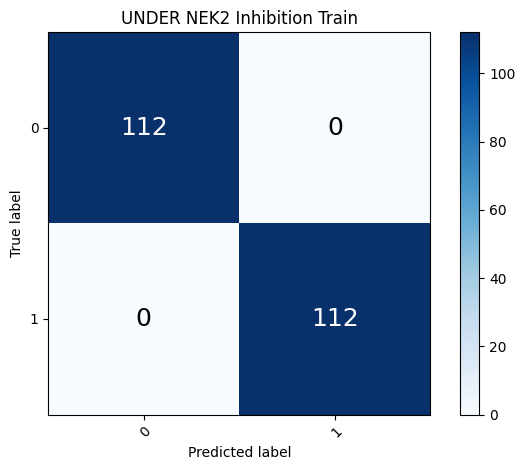

<Figure size 600x400 with 0 Axes>

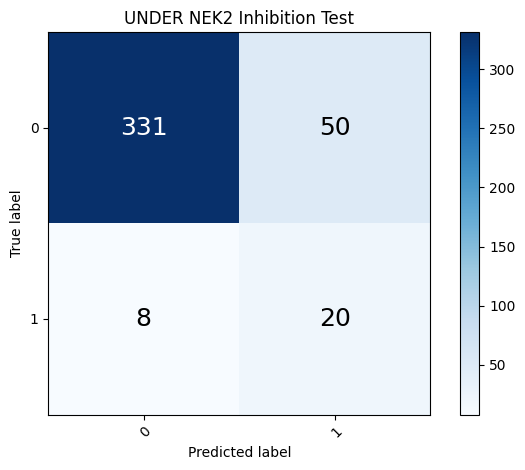

In [8]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
train_results1 = trainer1.gp_results(train_x, train_y, 'UNDER NEK2 Inhibition Train')

test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)
test_results1 = trainer1.gp_results(test_x, test_y, 'UNDER NEK2 Inhibition Test')


In [9]:
gp_metrics = [train_results1, test_results1]
with open('nek2_inhib_gp_metrics_UNDER.pkl', 'wb') as file: 
    pickle.dump(gp_metrics, file) 
gp_metrics

[{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'specificity': 1.0},
 {'accuracy': 0.8581907090464548,
  'precision': 0.2857142857142857,
  'recall': 0.7142857142857143,
  'specificity': 0.868766404199475}]

In [11]:
# train_pred = train_observed_pred
train_observed_pred.mean.numpy()
train_pred_variance2D = train_observed_pred.variance.numpy()
# test_pred = test_observed_pred
test_observed_pred.mean.numpy()
test_pred_variance2D=test_observed_pred.variance.numpy()
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
var_min, var_max


(1.1312462, 9.010485)

In [12]:

train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
train_prob_stds = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).std(0)
train_prob_stds.shape

lower, upper = test_observed_pred.confidence_region()


pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
prob_stds = (pred_samples / pred_samples.sum(-2, keepdim=True)).std(0)


In [13]:
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()
train_perf_df['mean_pred_class0'] = train_observed_pred.mean.numpy()[0,]
train_perf_df['mean_pred_class1'] = train_observed_pred.mean.numpy()[1,]
train_perf_df['y'] = train_y
train_perf_df['y_pred'] = train_pred_means.max(0)[1]
train_perf_df['var_pred_class0']=train_observed_pred.variance.numpy()[0,]
train_perf_df['var_pred_class1']=train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_prob_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_prob_class1'] = train_probabilities.numpy()[1,]
train_perf_df['pred_prob_std_class0'] = train_prob_stds.numpy()[0,]
train_perf_df['pred_prob_std_class1'] = train_prob_stds.numpy()[1,]

test_perf_df['mean_pred_class0'] = test_observed_pred.mean.numpy()[0,]
test_perf_df['mean_pred_class1'] = test_observed_pred.mean.numpy()[1,]
test_perf_df['y'] = test_y
test_perf_df['y_pred'] = test_pred_means.max(0)[1]
test_perf_df['var_pred_class0']=test_observed_pred.variance.numpy()[0,]
test_perf_df['var_pred_class1']=test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_prob_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_prob_class1'] = probabilities.numpy()[1,]
test_perf_df['pred_prob_std_class0'] = prob_stds.numpy()[0,]
test_perf_df['pred_prob_std_class1'] = prob_stds.numpy()[1,]

train_perf_df.to_csv("NEK2_inhib_UNDER_train_perf.csv", index=False)
test_perf_df.to_csv("NEK2_inhib_UNDER_test_perf.csv", index=False)

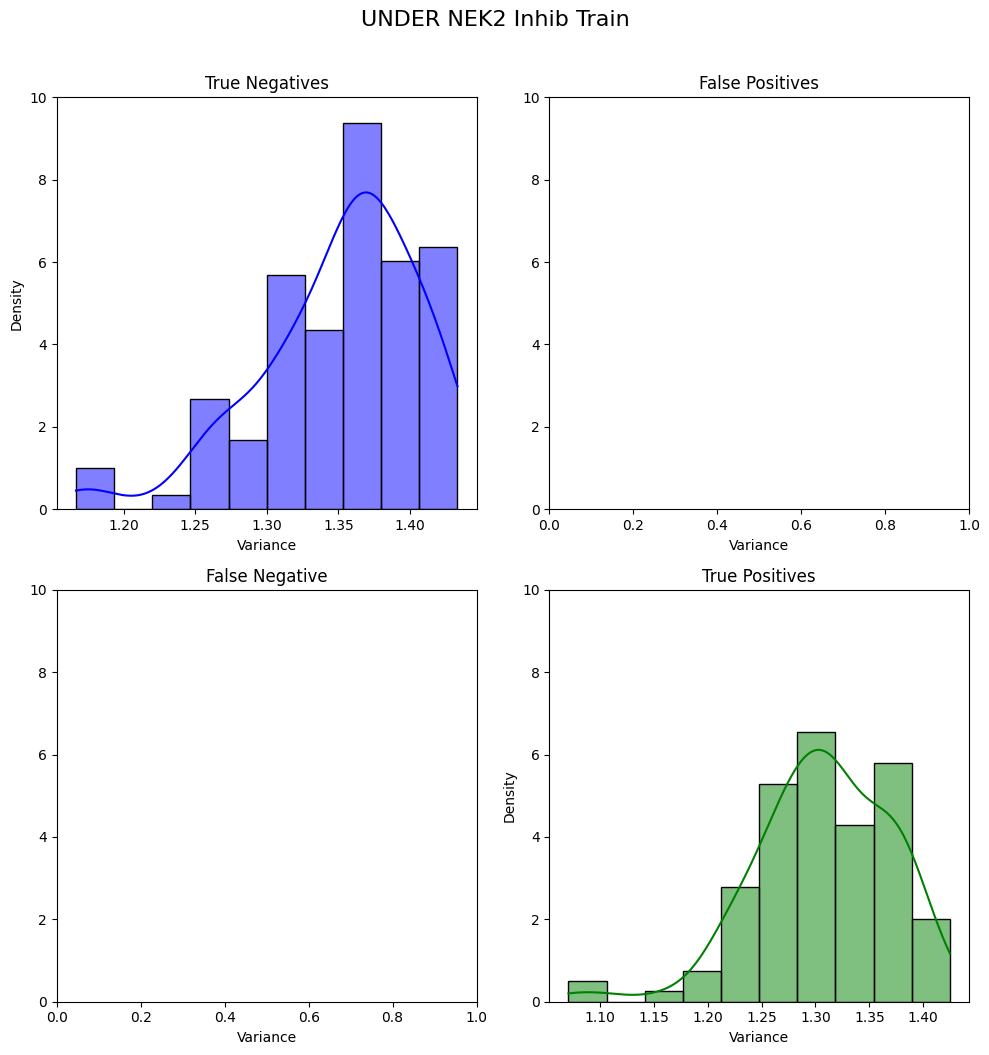

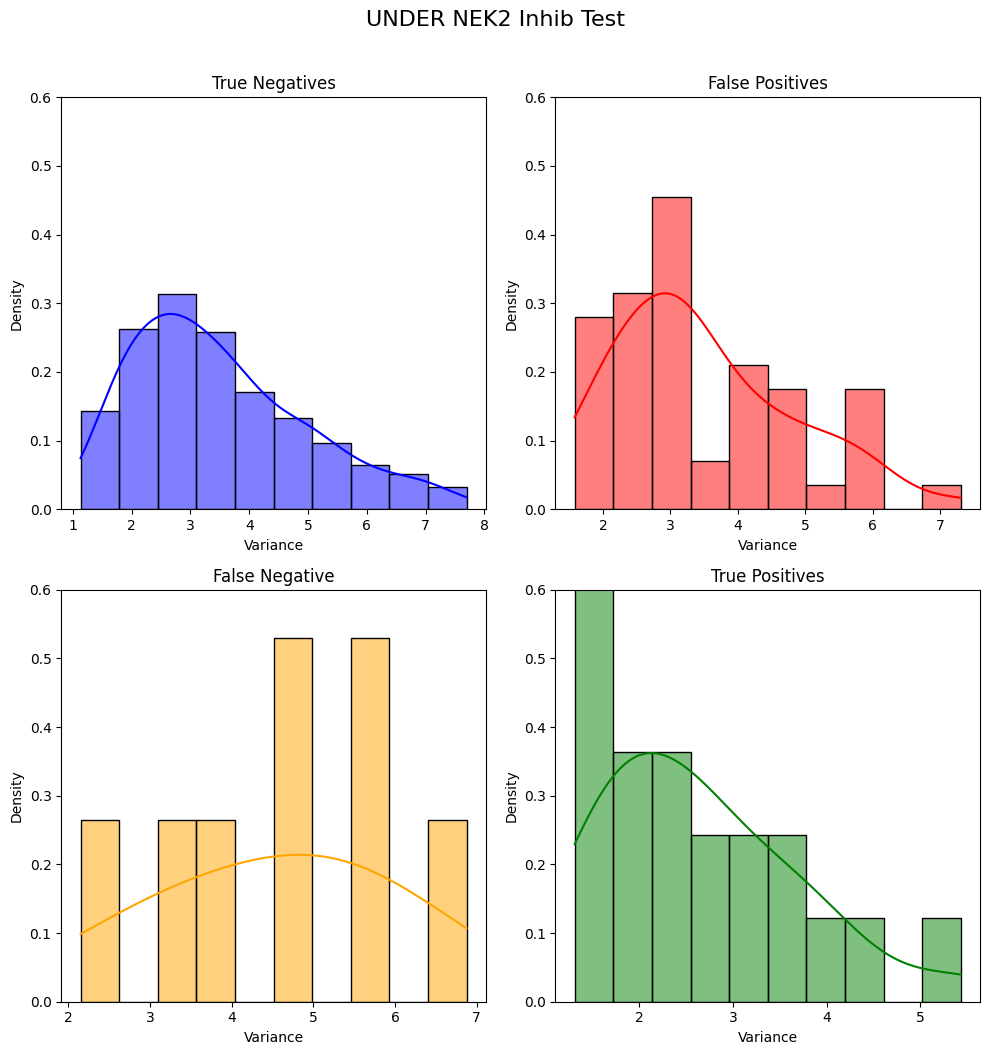

In [17]:
plot_cm_dist_kdedensity(train_observed_pred, train_pred, train_y, 'UNDER NEK2 Inhib Train',10)
plot_cm_dist_kdedensity(test_observed_pred, test_pred, test_y, 'UNDER NEK2 Inhib Test',.6)

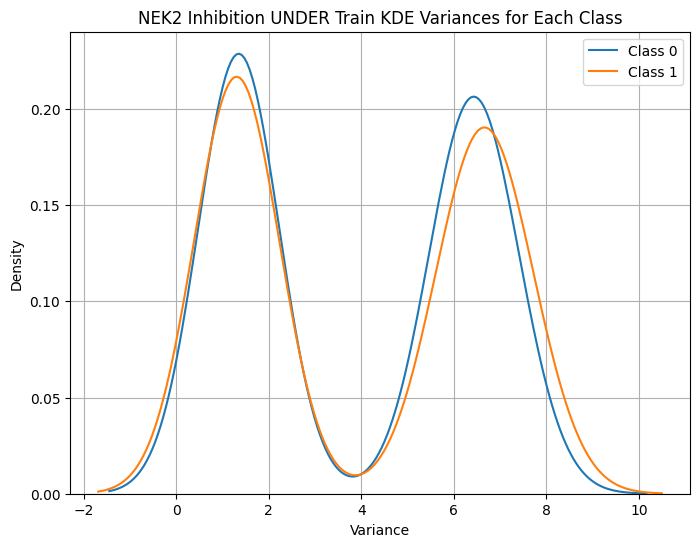

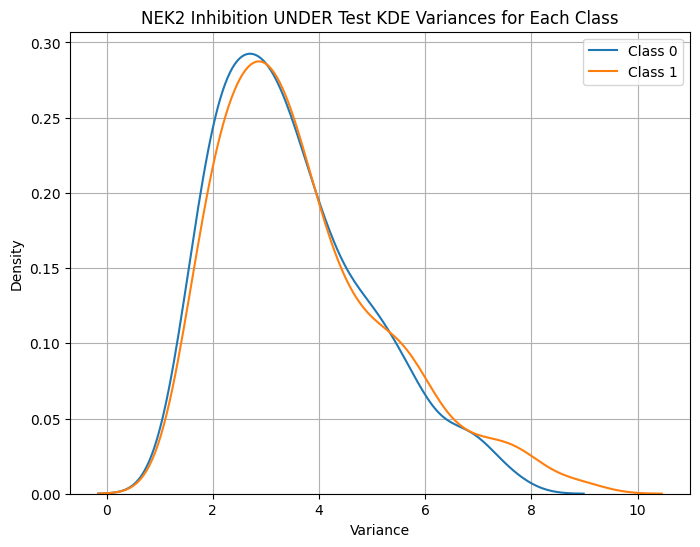

In [18]:
plot_kde(train_observed_pred, 'NEK2 Inhibition UNDER Train')
plot_kde(test_observed_pred, 'NEK2 Inhibition UNDER Test')
# plot_hist(test_observed_prt')


In [19]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]

(2, 409)


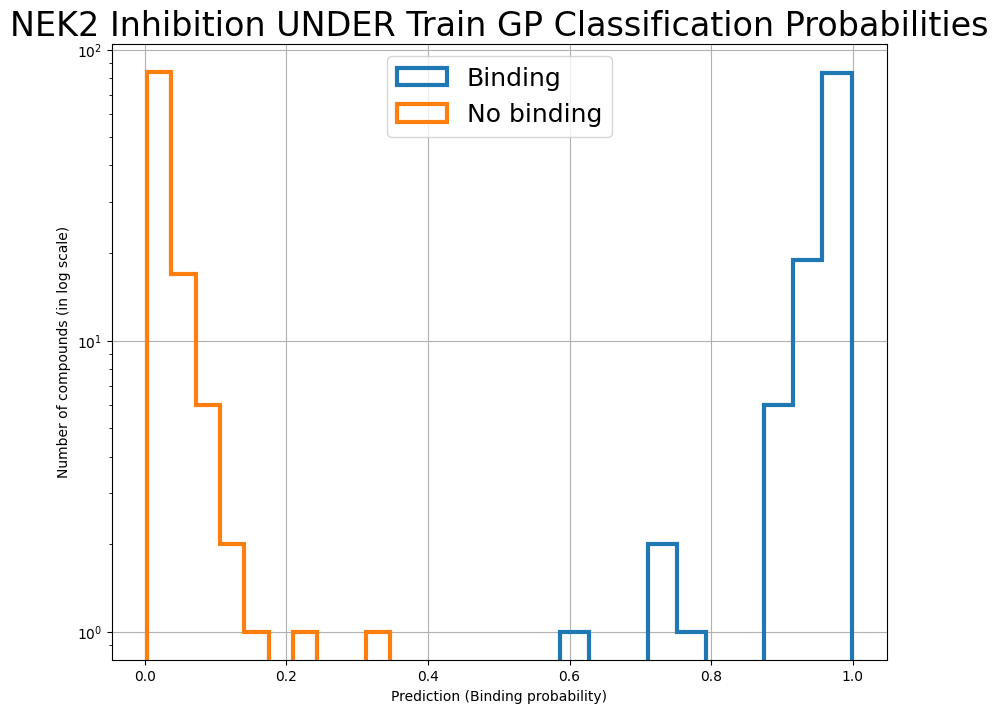

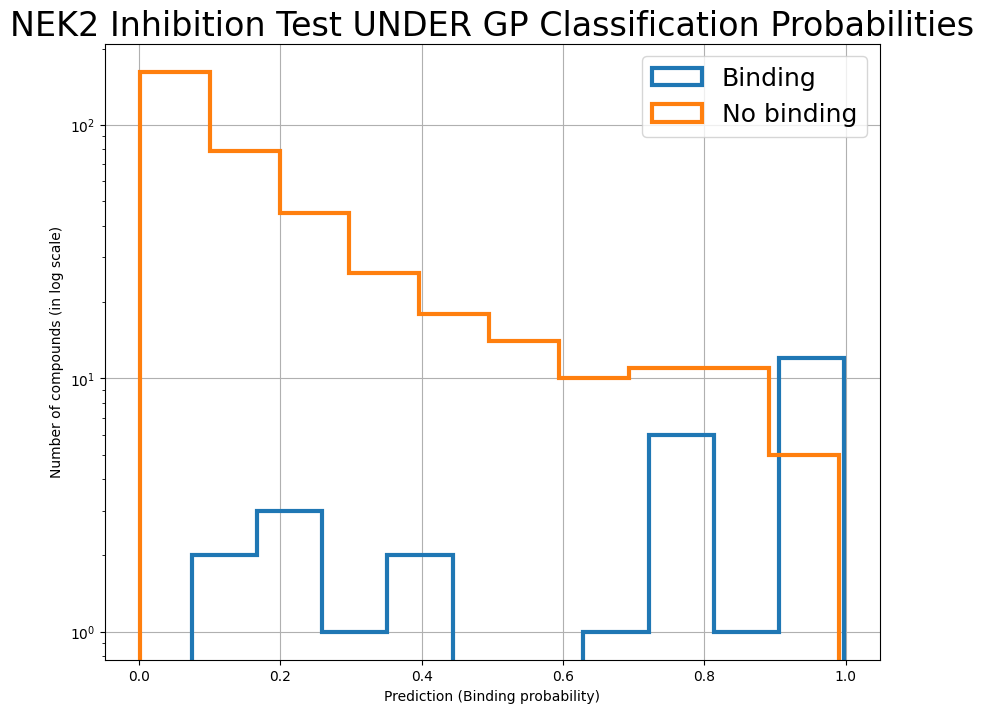

In [20]:

plot_prob_hist(train_probabilities, train_y, 'NEK2 Inhibition UNDER Train GP Classification Probabilities', 'Binding')
plot_prob_hist(probabilities, test_y, 'NEK2 Inhibition Test UNDER GP Classification Probabilities', 'Binding')

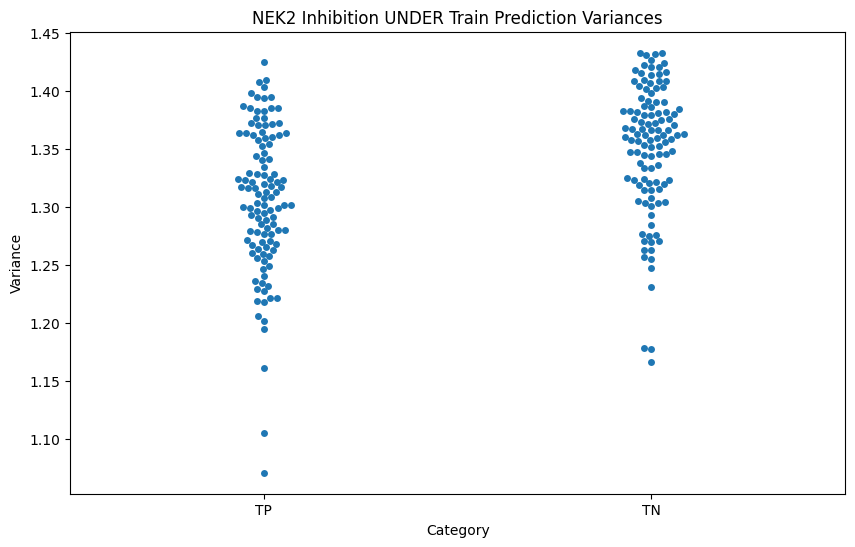

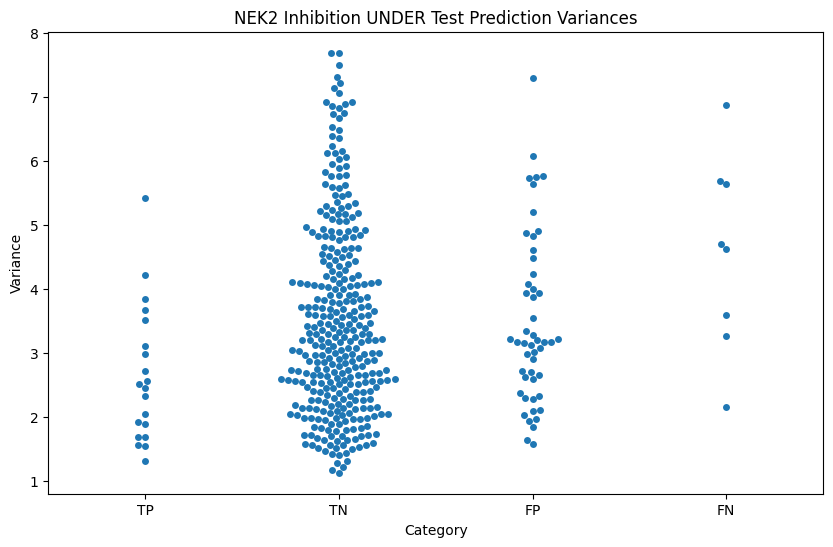

In [21]:
plot_swarmplot(train_pred, train_y, train_observed_pred,'NEK2 Inhibition UNDER Train Prediction Variances')
plot_swarmplot(test_pred, test_y, test_observed_pred,'NEK2 Inhibition UNDER Test Prediction Variances')

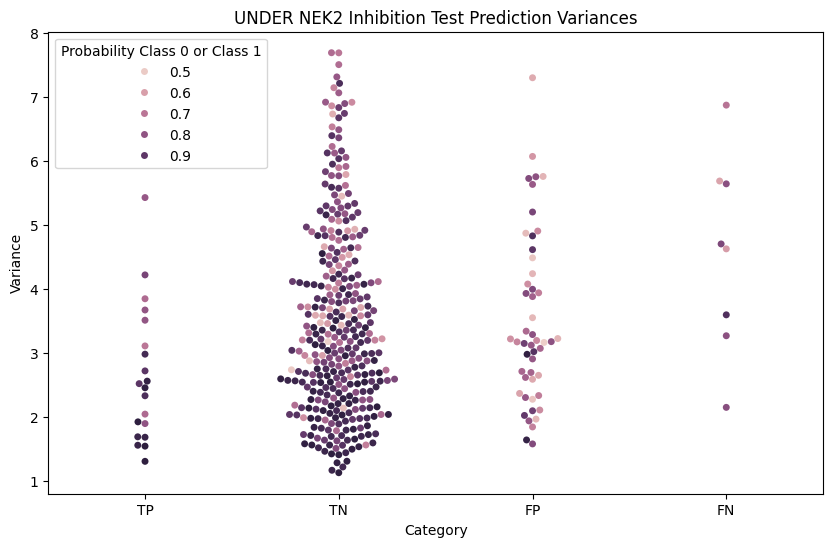

In [23]:
swarm_by_var_and_prob(test_pred, test_y, test_observed_pred,probabilities,'UNDER NEK2 Inhibition Test Prediction Variances')

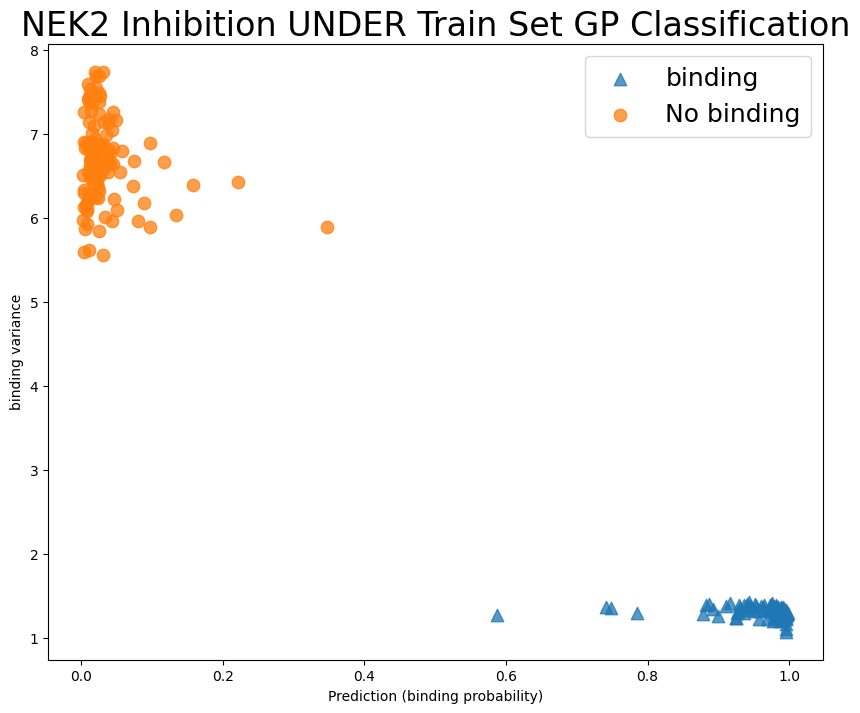

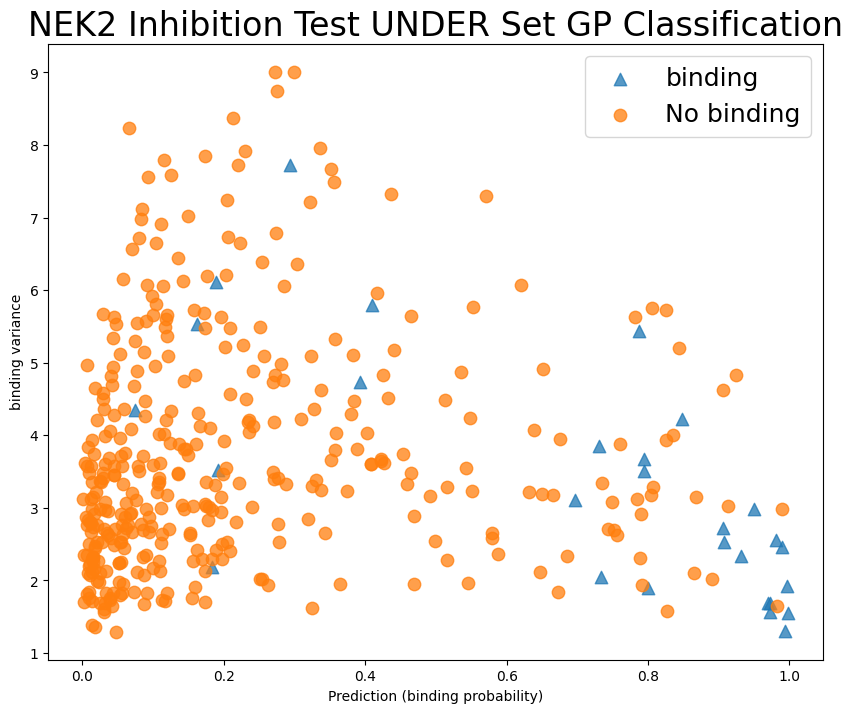

In [22]:
probabilities_vs_var(train_y, train_probabilities, train_observed_pred,'NEK2 Inhibition UNDER Train Set GP Classification', 'binding')
probabilities_vs_var(test_y, probabilities, test_observed_pred,'NEK2 Inhibition Test UNDER Set GP Classification', 'binding')